# Coincidence  
## การหา leading indicator เพื่อมา predict ราคาของสินทรัพย์ต่างๆ 
### เช่นการนำราคาของลูกๆ PTT มา predict ราคา PTT
### สามารถใช้ดูว่าราคาของ PTT(y) นั้นราคา over หรือ undervalue เหมือนใช้แกงค์ตัวแปร X มาเพื่อคำนวนราคา fair value ของตัวแปรตาม (y)
#### อาจทำในกลุ่มแบงค์ เพื่อดูว่ามีตัวไหนราคาฉีกไปหรือป่าว อาจแทงให้ราคากลับเข้าหาราคาที่ควรจะเป็น หรือ ใช้กลุ่มตัวลูกๆ มาเพื่อกำหนดตัวหุ้นแม่ หรืออาจใช้ราคาของเหรียญตัวไหนมากำหนด fair price ของเหรียญไหน ถ้าไม่ใช่เหรียญที่มีผลต่อกัน อาจจะต้องระวังเหตุการสำคัญที่ทำให้ราคาผิดเปลี่ยนไปจากปกติ

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
start = '2017-01-01'
end = '2022-01-01'

In [3]:
data = yf.download('PTT.BK CL=F GPSC.BK PTTEP.BK PTTGC.BK', start= start, end= end)

[*********************100%***********************]  5 of 5 completed


In [4]:
df = data['Adj Close']

In [5]:
df = df.fillna(method= 'ffill')

# ใช้ ffill forwwrd fill ในการ fill na (เช่น24ว่าง เอา23 ใส่ในช่อง 24ด้วย)
# จะทำให้ไม่เสีย data ในวันนั้นๆไป

In [6]:
df = df.pct_change().dropna()

In [7]:
df[(df.iloc[:,1:] == 0).all(1)]

,CL=F,GPSC.BK,PTT.BK,PTTEP.BK,PTTGC.BK
Date,,,,,
2017-01-13,-0.012073,0.0,0.0,0.0,0.0
2017-02-13,-0.017267,0.0,0.0,0.0,0.0
2017-04-06,0.010753,0.0,0.0,0.0,0.0
2017-04-13,0.001318,0.0,0.0,0.0,0.0
2017-05-01,-0.009933,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2021-10-13,-0.002480,0.0,0.0,0.0,0.0
2021-10-22,0.015273,0.0,0.0,0.0,0.0
2021-12-06,0.048747,0.0,0.0,0.0,0.0


In [8]:
df = df[~(df.iloc[:,1:] == 0).all(1)]

In [9]:
(df == 0).sum()

CL=F         45
GPSC.BK     158
PTT.BK      206
PTTEP.BK    134
PTTGC.BK    125
dtype: int64

In [10]:
df = df[['CL=F', 'GPSC.BK', 'PTTEP.BK', 'PTTGC.BK', 'PTT.BK']]

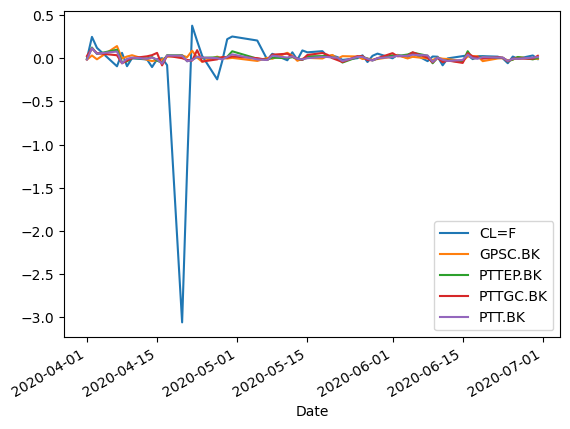

In [11]:
df.loc['2020-04' : '2020-06'].plot()
plt.show()

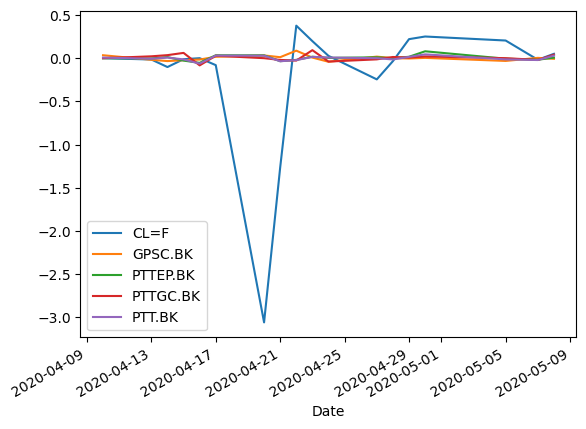

In [12]:
df.loc['2020-04-10' : '2020-05-10'].plot()
plt.show()

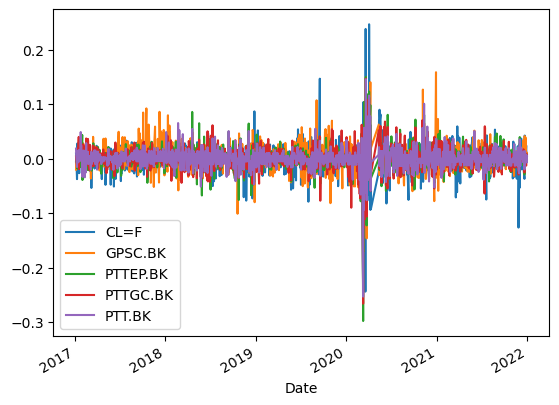

In [13]:
start_remove = pd.to_datetime('2020-04-10')
end_remove = pd.to_datetime('2020-05-10')
## ใช้ to_datetime เป็นตัวกำหนดวันที่ให้กับตัวแปร เพื่อไไปใช้ต่อในการกำกับ index
df = df.loc[(df.index < start_remove) | (df.index > end_remove)]

df.plot()
plt.show()

In [19]:
X = df.iloc[:1000, :-1] # 1000 rows แรก และไม่เอาcolumn สุดท้าย
y = df.iloc[:1000,-1] # 1000rows แรก และ เอาแค่ column สุดท้าย

In [15]:
Lower_Limit = df.quantile(0.01)
Upper_Limit = df.quantile(0.99)

In [16]:
df = df[~((df < Lower_Limit) | (df > Upper_Limit)).any(1)]


In [17]:
df.describe()

,CL=F,GPSC.BK,PTTEP.BK,PTTGC.BK,PTT.BK
count,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000
mean,0.000593,0.000865,0.000768,0.000431,0.000225
std,0.019000,0.019006,0.015322,0.016262,0.013182
min,-0.075685,-0.059761,-0.053498,-0.049383,-0.040000
25%,-0.009058,-0.009547,-0.008380,-0.009475,-0.006656
50%,0.001850,0.000000,0.000000,0.000000,0.000000
75%,0.011958,0.010545,0.008547,0.009732,0.006656
max,0.059211,0.069697,0.064394,0.058140,0.052045


In [35]:
## implement K-Fold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

model = LinearRegression()
scores = cross_val_score(model, X, y, scoring= 'r2', cv=10)
scores

array([0.30576121, 0.44708594, 0.30865829, 0.49829008, 0.5616584 ,
       0.43553934, 0.54166232, 0.60647903, 0.38595931, 0.48493183])

In [23]:
df.corr()

,CL=F,GPSC.BK,PTTEP.BK,PTTGC.BK,PTT.BK
CL=F,1.000000,0.015722,0.164724,0.123905,0.157810
GPSC.BK,0.015722,1.000000,0.158269,0.210742,0.213606
PTTEP.BK,0.164724,0.158269,1.000000,0.469872,0.632394
PTTGC.BK,0.123905,0.210742,0.469872,1.000000,0.548473
PTT.BK,0.157810,0.213606,0.632394,0.548473,1.000000


In [29]:
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size= 0.2, random_state= 12)

scores = cross_val_score(model, X_train, y_train, scoring= 'r2', cv= 5)
scores

array([0.54687105, 0.4939996 , 0.4306943 , 0.56183863, 0.38713364])

In [30]:
model = LinearRegression()
reg = model.fit(X_train, y_train)

In [31]:
y_pred = reg.predict(X_test)

In [49]:
reg.score(X_test, y_test)

0.3563543957432592

In [41]:
print("MAE = ",  metrics.mean_absolute_error(y_test,y_pred))
print("MSE = ",  metrics.mean_squared_error(y_test,y_pred))
print("RMSE = ", np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
metrics.r2_score(y_test, y_pred)

MAE =  0.007653195330810587
MSE =  0.00010358244616777604
RMSE =  0.010177546176155431


0.3563543957432592

In [51]:
reg.coef_ 

array([0.02160772, 0.04804779, 0.42312464, 0.25376859])

In [57]:
live_data = reg.predict(df.iloc[1000:,:-1])
live_data

# สร้าง data ขึ้นมาเพื่อเอาไปใส่ใน dataframe และเปรียบเทียบ predict กับ actual ด้วยตา

array([ 1.67652598e-03, -1.03060081e-02,  6.36908858e-03,  2.07003599e-03,
        5.60856514e-03,  7.57580753e-03, -1.70153249e-02, -1.92046982e-02,
       -4.45980826e-03, -1.31016834e-02, -3.44741850e-03,  9.91042132e-03,
       -1.42275389e-02, -1.37288699e-02,  9.20267605e-03,  4.02409939e-03,
       -7.21612611e-03, -4.32915715e-03,  4.38878338e-03, -2.30731301e-02,
        1.52139452e-02,  1.64416702e-03,  1.85307946e-03, -1.18583339e-02,
       -1.19376543e-03,  5.36477289e-03,  1.21114584e-02, -5.44884406e-03,
        1.75074299e-04,  7.58096027e-03, -3.55838457e-03, -1.20105424e-03,
       -1.55966039e-02, -1.63715050e-02,  2.40918116e-02,  2.30509082e-02,
        4.95105466e-03, -4.89475146e-04,  5.86897553e-03,  2.64941297e-02,
       -5.72835321e-03, -1.34363003e-02,  5.06606540e-03, -4.11516396e-04,
       -1.27336677e-02, -6.91697202e-03, -4.84216318e-03,  6.73341217e-05,
        6.58826252e-04,  7.81475094e-03,  1.80455410e-02, -2.80824907e-03,
        3.36197047e-03, -

In [55]:
test = df.iloc[1000:]

In [56]:
test['Pred'] = live_data
test

<ipython-input-56-6ca778292043>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Pred'] = live_data


,CL=F,GPSC.BK,PTTEP.BK,PTTGC.BK,PTT.BK,Pred
Date,,,,,,
2021-06-29,0.000960,0.000000,0.000000,0.008439,-0.006289,0.001677
2021-06-30,0.006714,0.006897,-0.016807,-0.012552,-0.006329,-0.010306
2021-07-01,0.023955,0.034247,0.008547,0.004237,-0.006369,0.006369
2021-07-02,-0.000930,-0.013245,0.000000,0.012658,-0.006410,0.002070
2021-07-05,0.000000,0.030201,0.008475,0.004167,0.006452,0.005609
...,...,...,...,...,...,...
2021-12-24,0.000000,0.039157,-0.004237,0.004292,0.000000,0.000692
2021-12-27,0.024122,-0.002899,0.004255,-0.012821,-0.006579,-0.001557
2021-12-28,0.005425,0.011628,0.008475,0.008658,0.006623,0.005973


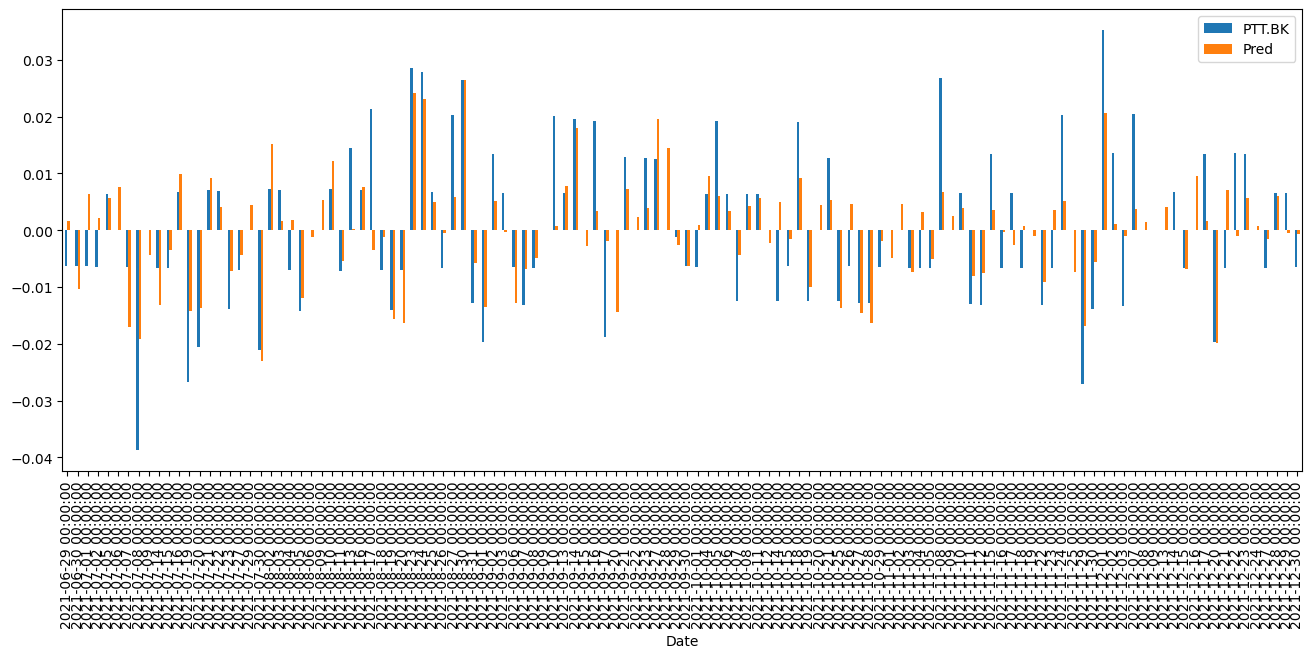

In [62]:
test.iloc[:, -2:].plot(kind= 'bar', figsize= (16,6))
plt.show()

In [68]:
cum = (test+1).cumprod()
cum

,CL=F,GPSC.BK,PTTEP.BK,PTTGC.BK,PTT.BK,Pred
Date,,,,,,
2021-06-29,1.000960,1.000000,1.000000,1.008439,0.993711,1.001677
2021-06-30,1.007681,1.006897,0.983193,0.995781,0.987421,0.991353
2021-07-01,1.031820,1.041379,0.991597,1.000000,0.981132,0.997667
2021-07-02,1.030860,1.027586,0.991597,1.012658,0.974843,0.999732
2021-07-05,1.030860,1.058621,1.000000,1.016878,0.981132,1.005340
...,...,...,...,...,...,...
2021-12-24,1.054099,1.200343,1.010308,1.059130,0.991822,0.976402
2021-12-27,1.079526,1.196864,1.014607,1.045552,0.985296,0.974882
2021-12-28,1.085383,1.210781,1.023206,1.054604,0.991822,0.980705


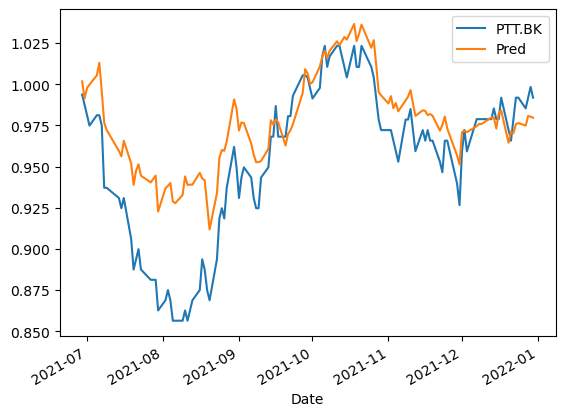

In [69]:
cum.iloc[:,-2:].plot()
plt.show()